In [25]:
import numpy as np
import pandas as pd
import os
from glob import glob
import matplotlib.pylab as plt
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy import signal
from sklearn.linear_model import LinearRegression

In [3]:
path = '/media/yongkp/CMAPSSData'

train_path_list = sorted(glob(path + '/train*'))
test_path_list = sorted(glob(path + '/test*'))
rul_path_list = sorted(glob(path + '/RUL*'))

In [4]:
col_name = ['unit number', 'time', 'op1', 'op2', 'op3']
temp = ['sensor %d'%(i+1) for i in range(23)]

load_col_name = col_name + temp
col_name = load_col_name[:-2]

In [5]:
train = []
for t_path in train_path_list:
    temp = pd.read_table(t_path, sep = ' ', header = None, names=load_col_name)
    train.append(temp[col_name])

test = []
for t_path in test_path_list:
    temp = pd.read_table(t_path, sep = ' ', header = None, names=load_col_name)
    test.append(temp[col_name])
    
RUL = []
for r_path in rul_path_list:
    temp = pd.read_table(r_path, header = None, names = ['RUL'])
    RUL.append(temp)

In [6]:
trains = pd.concat(train, axis = 0)
trains = trains.iloc[:,[2,3]]

tests = pd.concat(test, axis = 0)
tests = tests.iloc[:,[2,3]]

kmeans = KMeans(n_clusters=6, random_state=0).fit(trains)

In [7]:
scaler1 = MinMaxScaler().fit(train[0].iloc[:,2:])
FD001_norm1 = scaler1.transform(train[0].iloc[:,2:])
FD001_norm1 = np.concatenate([train[0].iloc[:,:2], FD001_norm1], axis = 1)

scaler2 = StandardScaler().fit(train[0].iloc[:,2:])
FD001_norm2 = scaler2.transform(train[0].iloc[:,2:])
FD001_norm2 = np.concatenate([train[0].iloc[:,:2], FD001_norm2], axis = 1)

In [8]:
FD001_norm1 = pd.DataFrame(FD001_norm1, columns = col_name)
FD001_norm1

,unit number,time,op1,op2,op3,sensor 1,sensor 2,sensor 3,sensor 4,sensor 5,...,sensor 12,sensor 13,sensor 14,sensor 15,sensor 16,sensor 17,sensor 18,sensor 19,sensor 20,sensor 21
0,1.0,1.0,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,...,0.633262,0.205882,0.199608,0.363986,0.0,0.333333,0.0,0.0,0.713178,0.724662
1,1.0,2.0,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,...,0.765458,0.279412,0.162813,0.411312,0.0,0.333333,0.0,0.0,0.666667,0.731014
2,1.0,3.0,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,...,0.795309,0.220588,0.171793,0.357445,0.0,0.166667,0.0,0.0,0.627907,0.621375
3,1.0,4.0,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,...,0.889126,0.294118,0.174889,0.166603,0.0,0.333333,0.0,0.0,0.573643,0.662386
4,1.0,5.0,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,...,0.746269,0.235294,0.174734,0.402078,0.0,0.416667,0.0,0.0,0.589147,0.704502
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100.0,196.0,0.477011,0.250000,0.0,0.0,0.686747,0.587312,0.782917,0.0,...,0.170576,0.558824,0.194344,0.656791,0.0,0.750000,0.0,0.0,0.271318,0.109500
20627,100.0,197.0,0.408046,0.083333,0.0,0.0,0.701807,0.729453,0.866475,0.0,...,0.211087,0.500000,0.188668,0.727203,0.0,0.583333,0.0,0.0,0.124031,0.366197
20628,100.0,198.0,0.522989,0.500000,0.0,0.0,0.665663,0.684979,0.775321,0.0,...,0.281450,0.529412,0.212148,0.922278,0.0,0.833333,0.0,0.0,0.232558,0.053991
20629,100.0,199.0,0.436782,0.750000,0.0,0.0,0.608434,0.746021,0.747468,0.0,...,0.208955,0.514706,0.203065,0.823394,0.0,0.583333,0.0,0.0,0.116279,0.234466


In [9]:
max_length = FD001_norm1.groupby('unit number').count().max()[0]

In [10]:
variance_check = FD001_norm1.groupby('unit number').std()
bol = variance_check > 0.1
select_index = np.where(bol.sum(axis = 0) == 100)[0] + 1
selected_col = [col_name[index] for index in select_index]
selected_col = selected_col[3:-2]
FD001_norm1[selected_col]

,sensor 2,sensor 3,sensor 4,sensor 11,sensor 15
0,0.183735,0.406802,0.309757,0.369048,0.363986
1,0.283133,0.453019,0.352633,0.380952,0.411312
2,0.343373,0.369523,0.370527,0.250000,0.357445
3,0.343373,0.256159,0.331195,0.166667,0.166603
4,0.349398,0.257467,0.404625,0.255952,0.402078
...,...,...,...,...,...
20626,0.686747,0.587312,0.782917,0.726190,0.656791
20627,0.701807,0.729453,0.866475,0.708333,0.727203
20628,0.665663,0.684979,0.775321,0.738095,0.922278
20629,0.608434,0.746021,0.747468,0.916667,0.823394


In [190]:
X = []
for i in range(100):
    bool_mask = FD001_norm1['unit number'] == (i+1)
    X.append(FD001_norm1[bool_mask][selected_col])

In [12]:
for key, data in enumerate(X):
    X[key] = pd.DataFrame(signal.resample(data, 192), columns = selected_col)

In [191]:
X[0]

,sensor 2,sensor 3,sensor 4,sensor 11,sensor 15
0,0.183735,0.406802,0.309757,0.369048,0.363986
1,0.283133,0.453019,0.352633,0.380952,0.411312
2,0.343373,0.369523,0.370527,0.250000,0.357445
3,0.343373,0.256159,0.331195,0.166667,0.166603
4,0.349398,0.257467,0.404625,0.255952,0.402078
...,...,...,...,...,...
187,0.765060,0.683235,0.684166,0.684524,0.753367
188,0.894578,0.547853,0.772451,0.732143,0.744132
189,0.731928,0.614345,0.737677,0.880952,0.759523
190,0.641566,0.682799,0.734639,0.773810,0.740669


In [192]:
def EWMA(data, alpha):
    for key, value in enumerate(data):
        data[key] = value.ewm(alpha = alpha).mean()
    return data
        
def MA(data, window):
    for key, value in enumerate(data):
        data[key] = value.rolling(window).mean()
    return data

In [193]:
ewma_X = EWMA(X, 0.1)
ma_X = MA(X, 30)

In [194]:
for key, data in enumerate(ewma_X):
    ewma_X[key] = data.dropna(axis=0)

5it [00:00, 1158.65it/s]


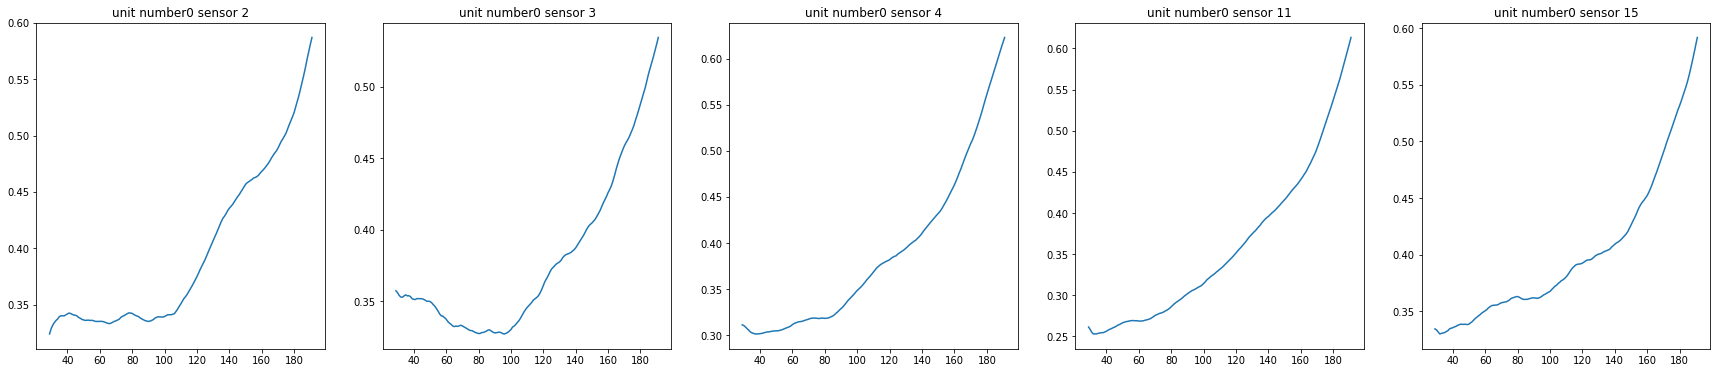

5it [00:00, 853.33it/s]


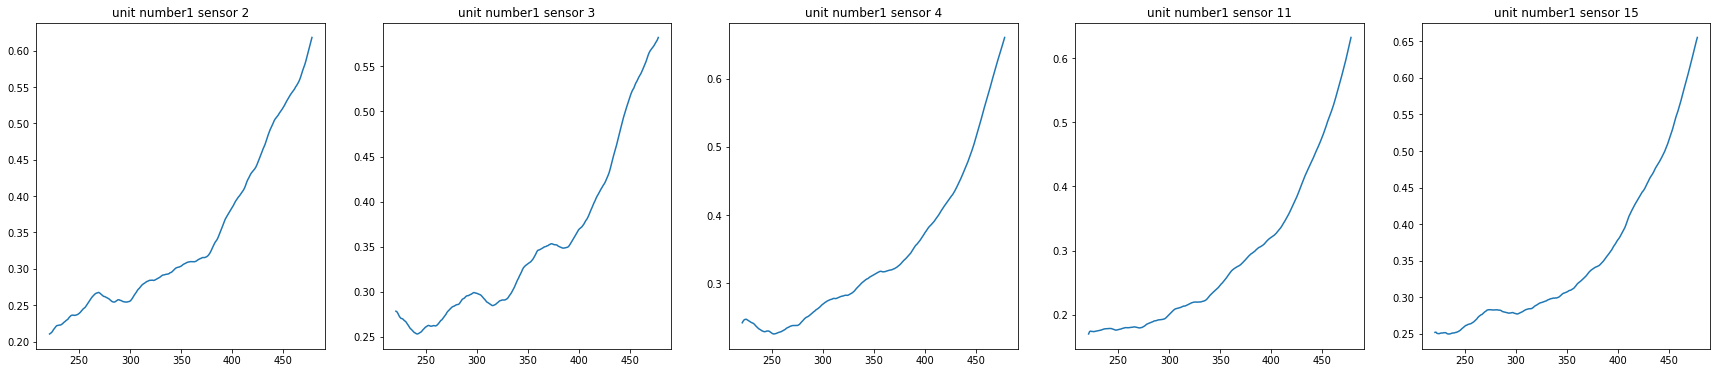

5it [00:00, 1222.97it/s]


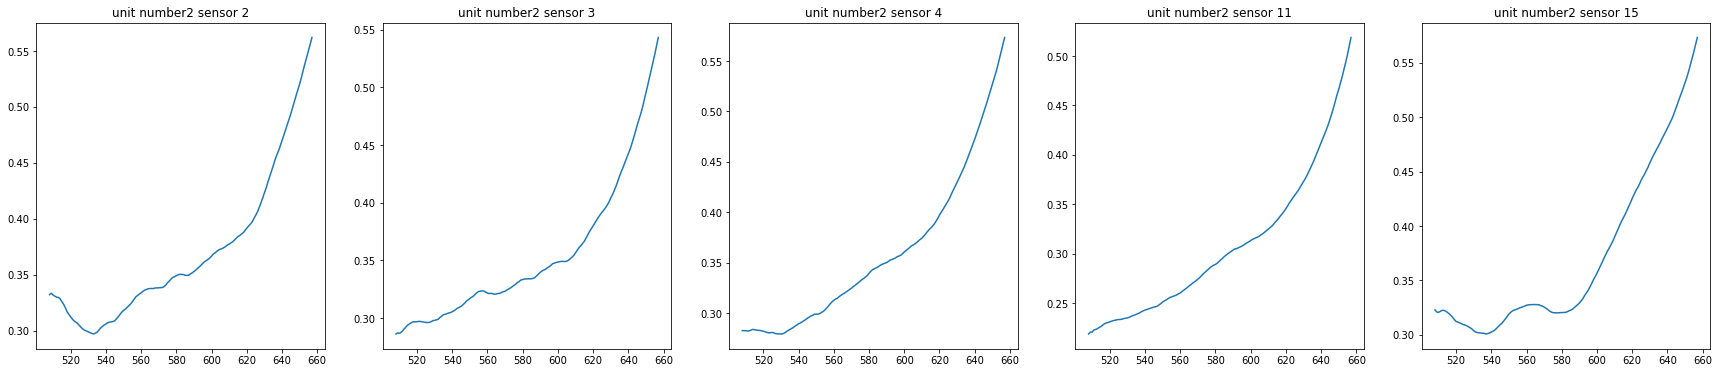

5it [00:00, 1221.48it/s]


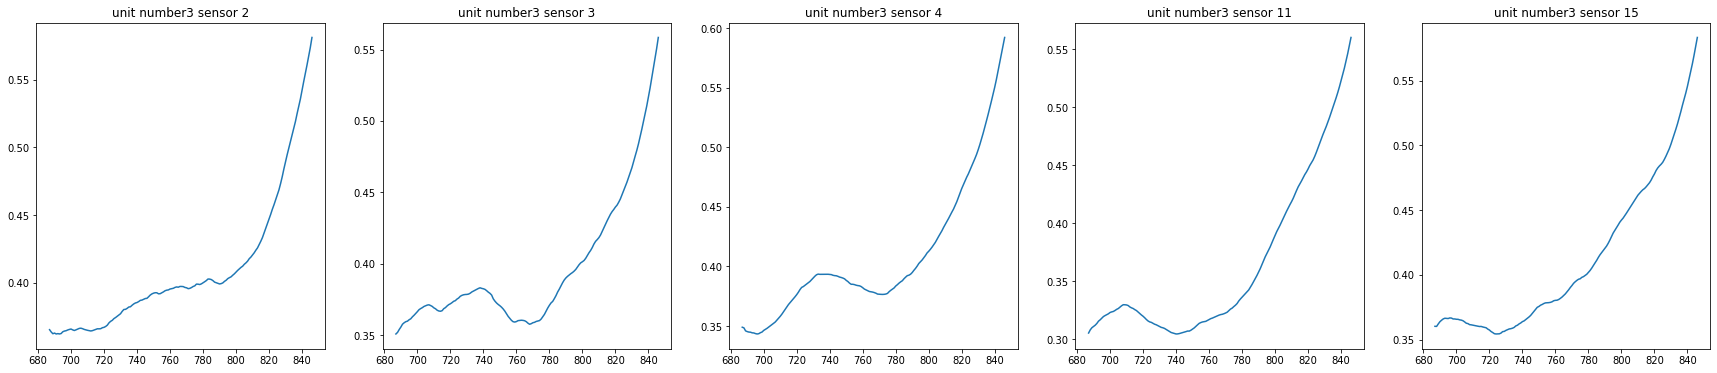

5it [00:00, 1129.51it/s]


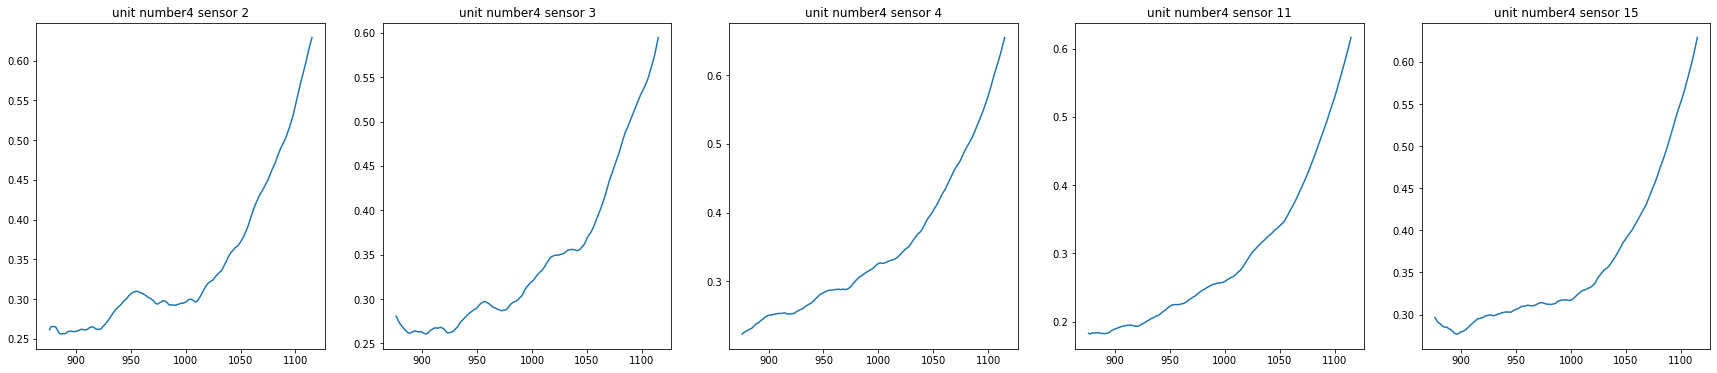

5it [00:00, 1218.71it/s]


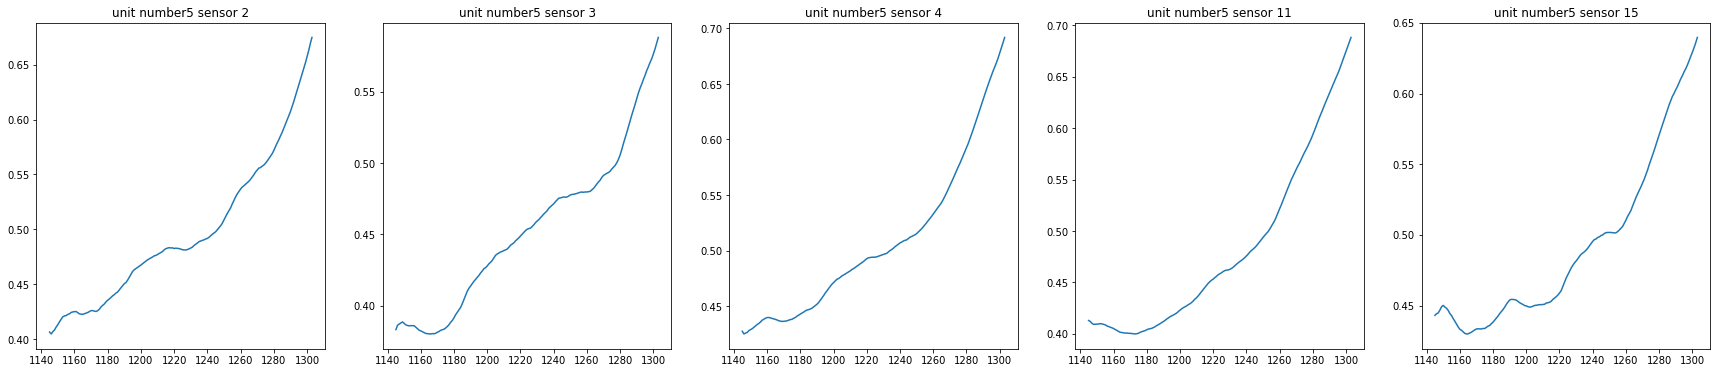

5it [00:00, 1140.56it/s]


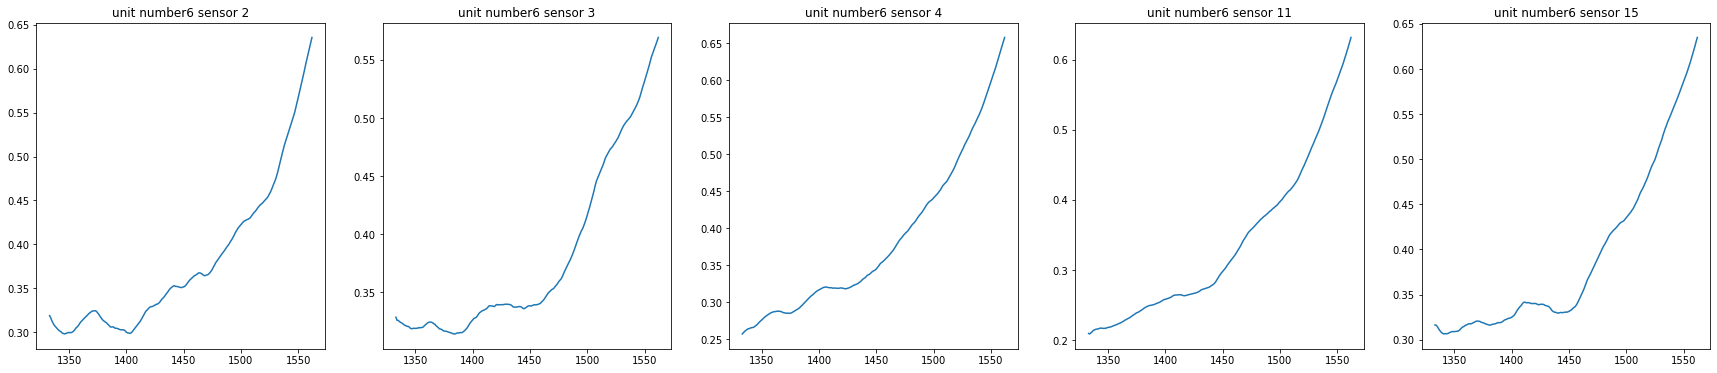

5it [00:00, 1130.11it/s]


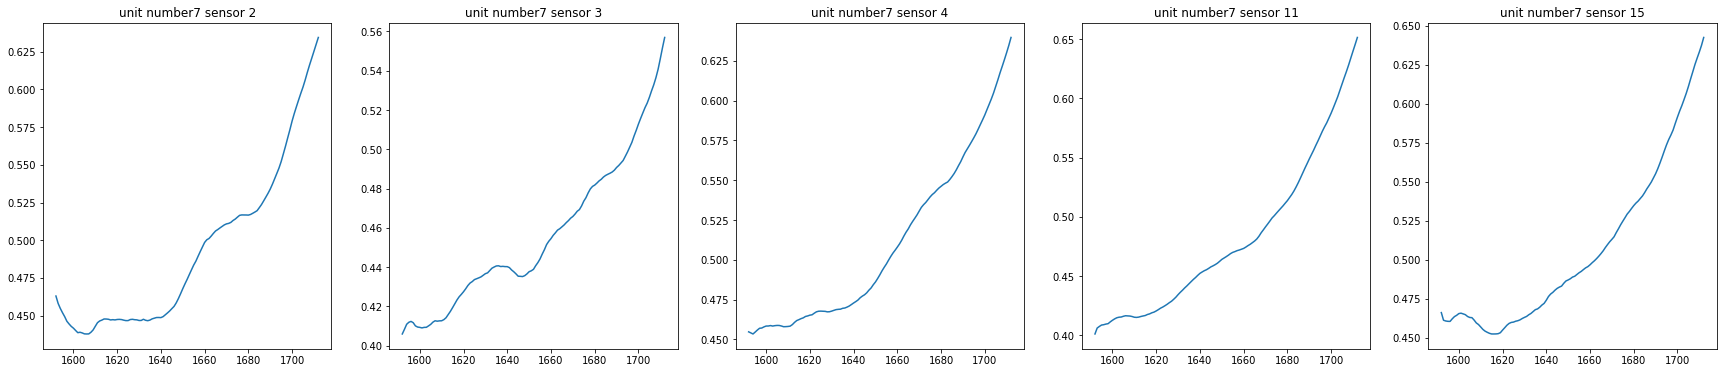

5it [00:00, 17.27it/s]


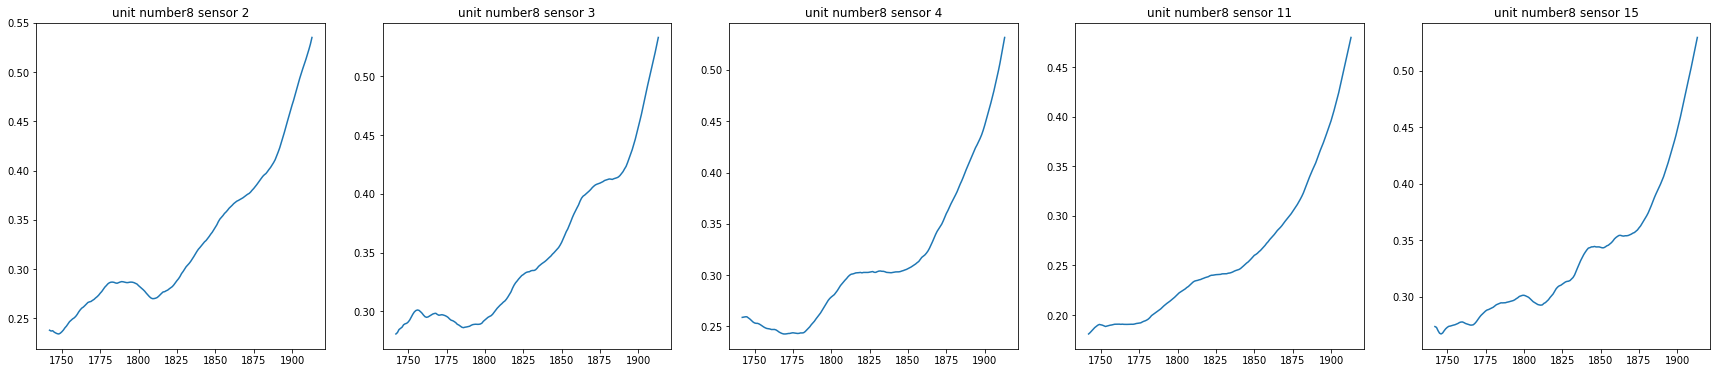

5it [00:00, 1266.09it/s]


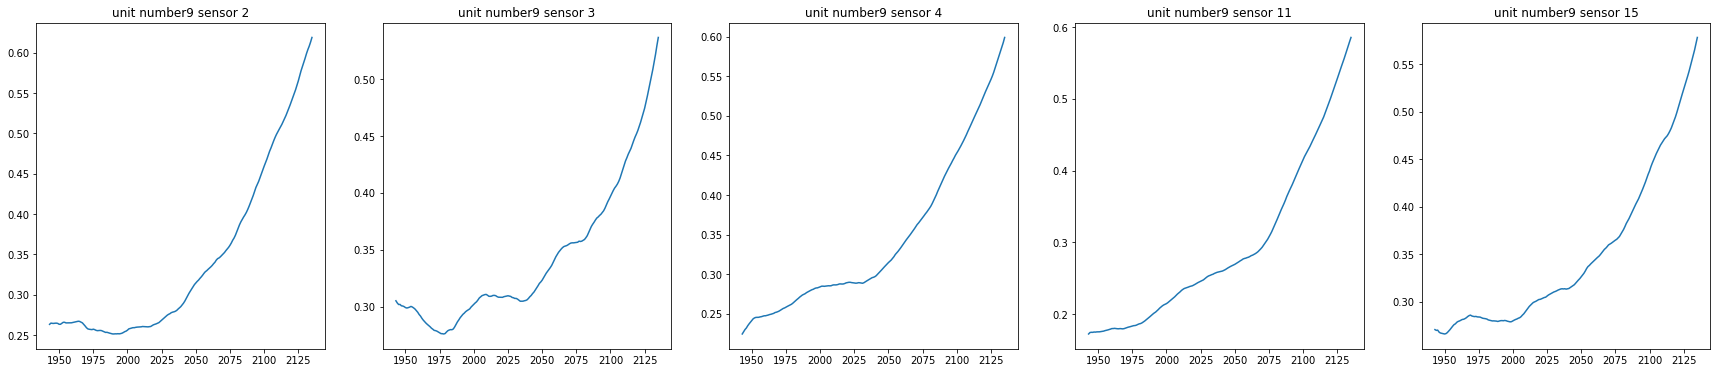

5it [00:00, 1261.37it/s]


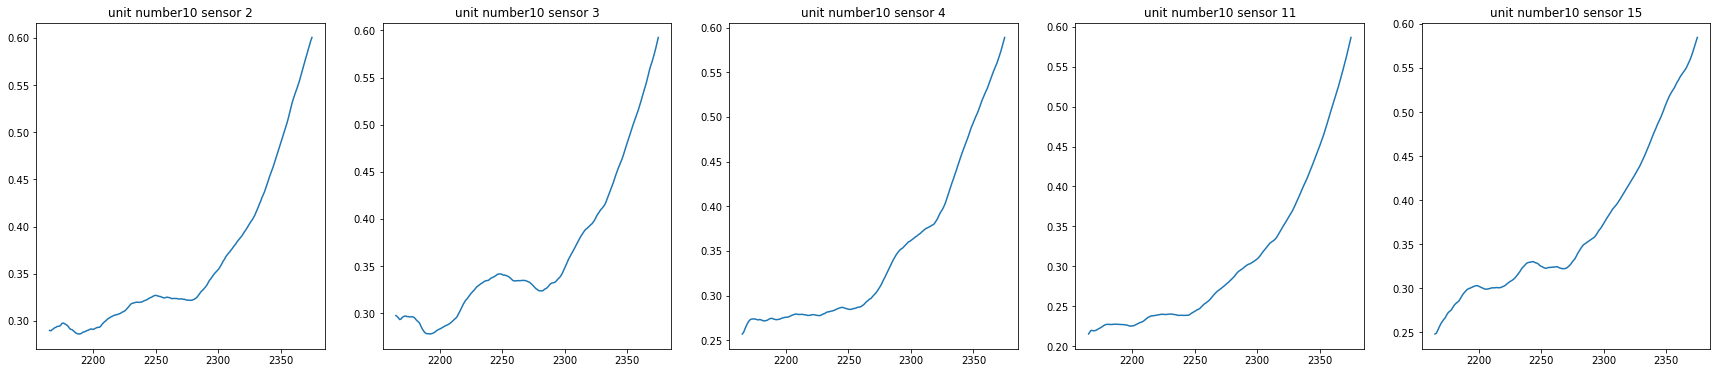

5it [00:00, 1460.72it/s]


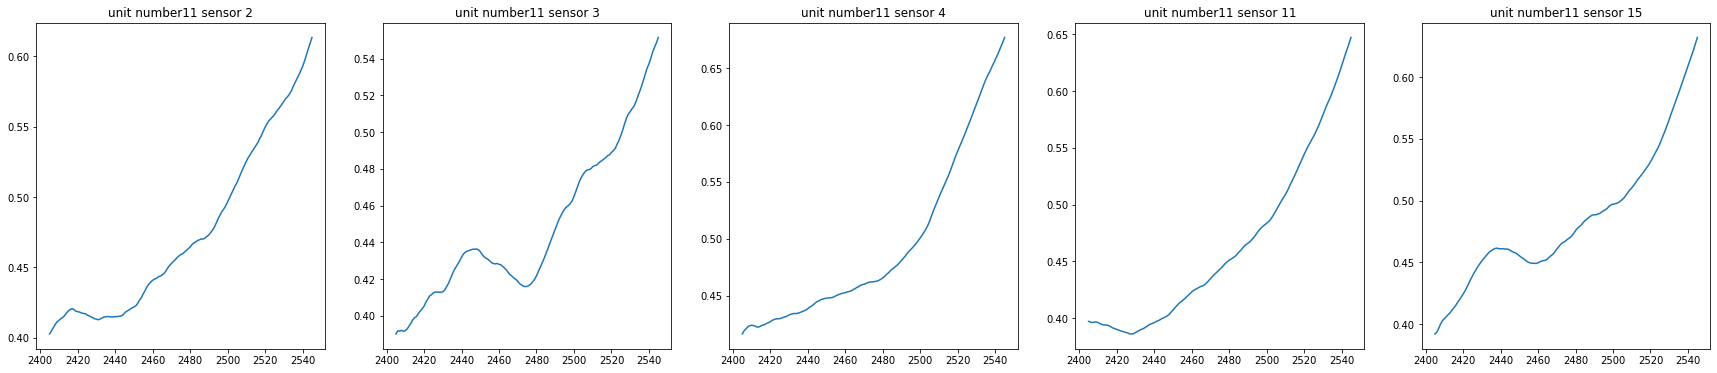

5it [00:00, 1156.35it/s]


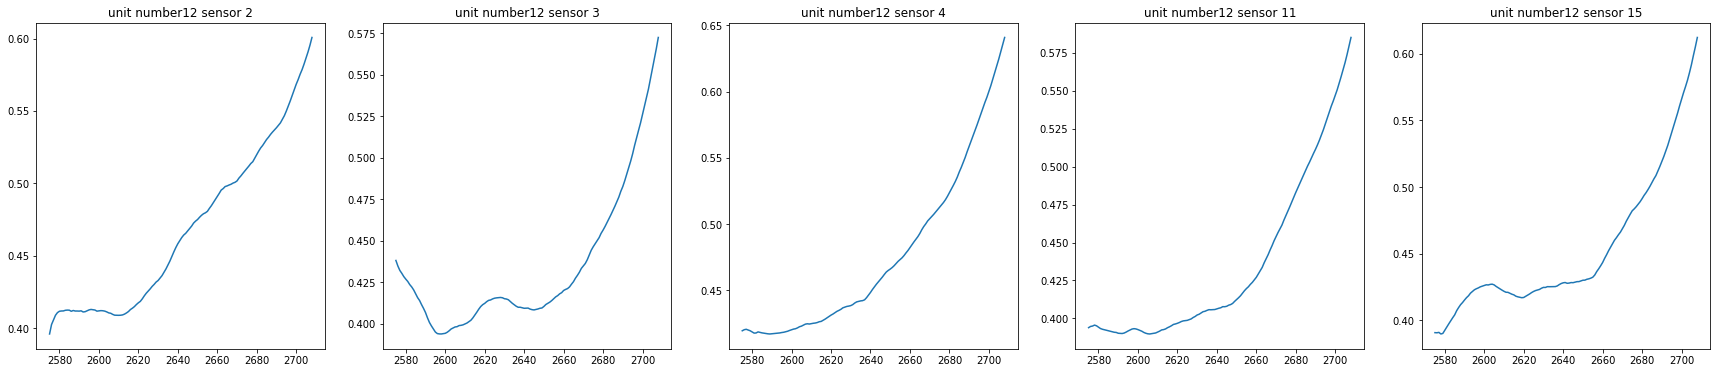

5it [00:00, 1250.54it/s]


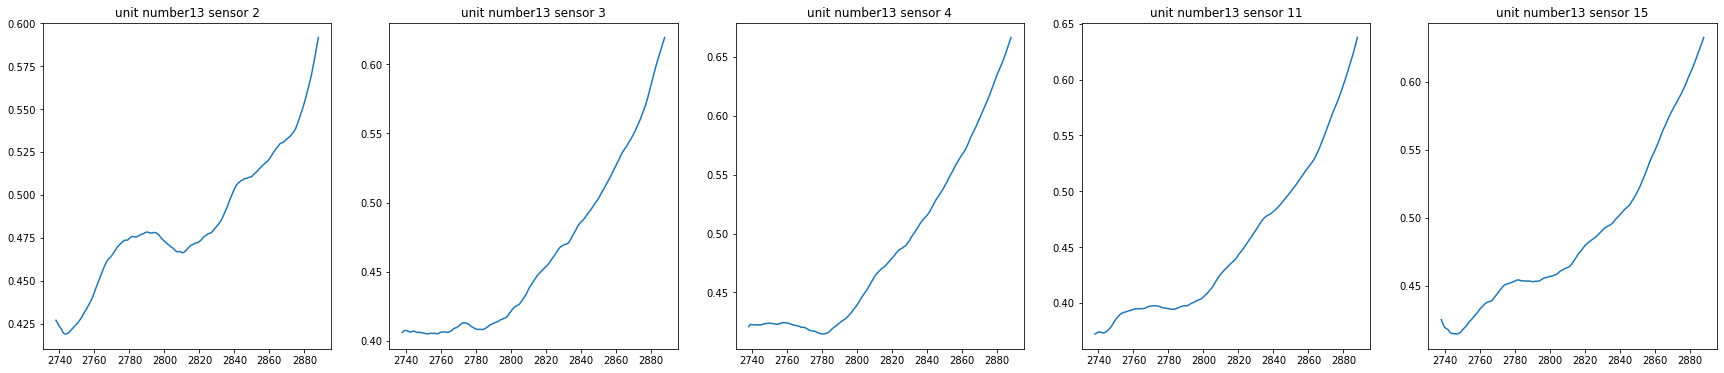

5it [00:00, 1257.51it/s]


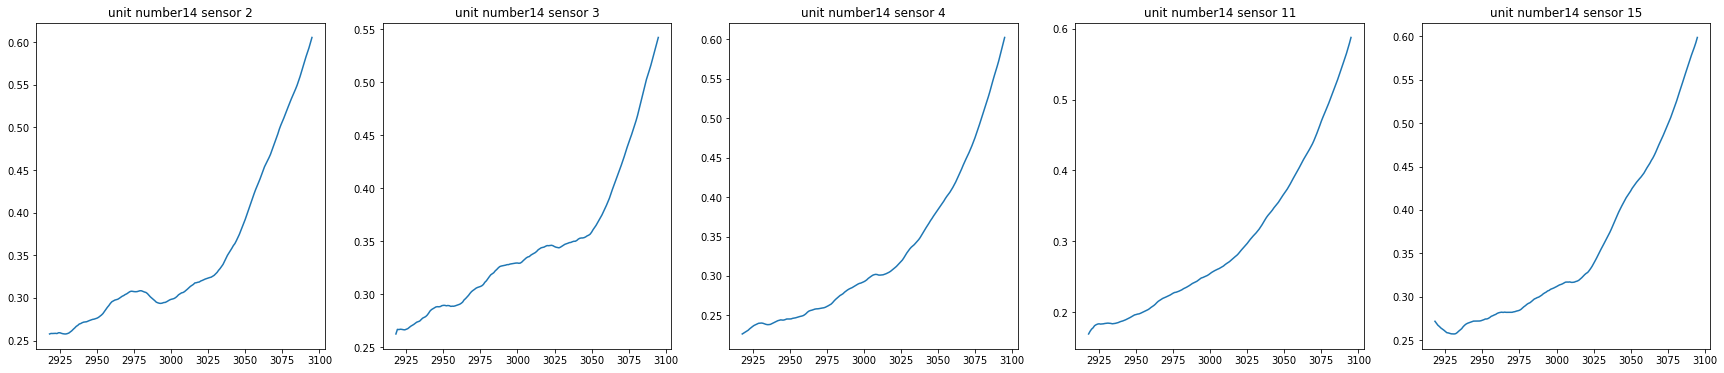

5it [00:00, 1236.97it/s]


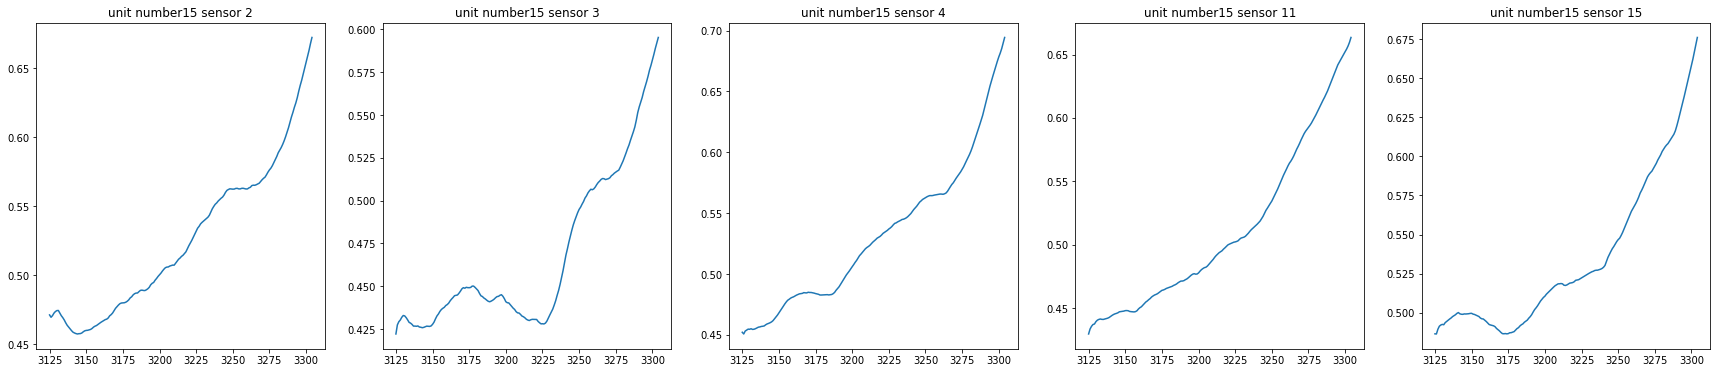

5it [00:00, 1256.68it/s]


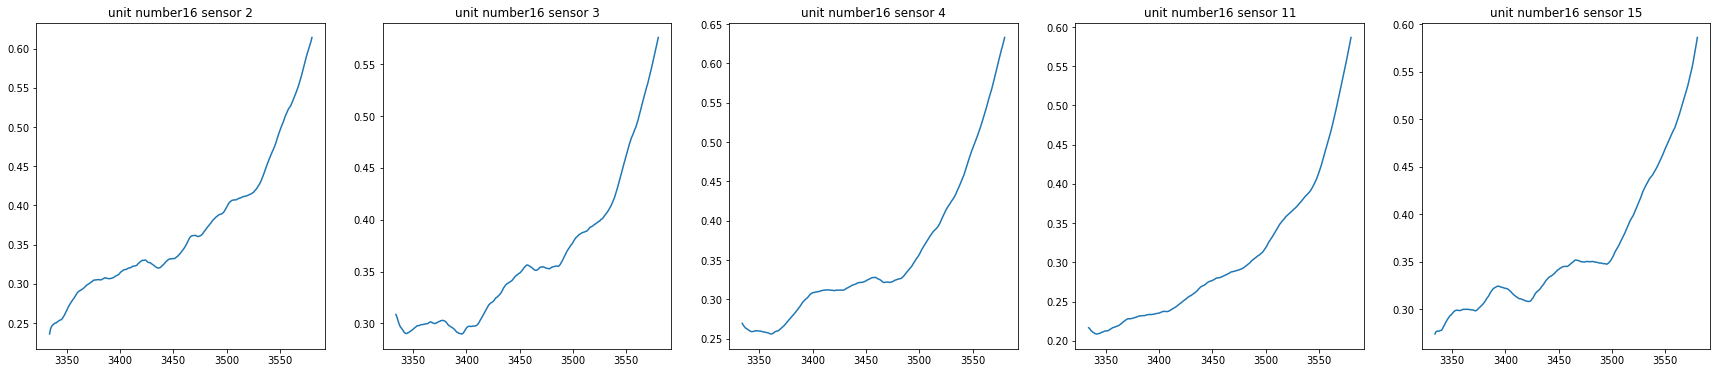

5it [00:00, 1248.53it/s]


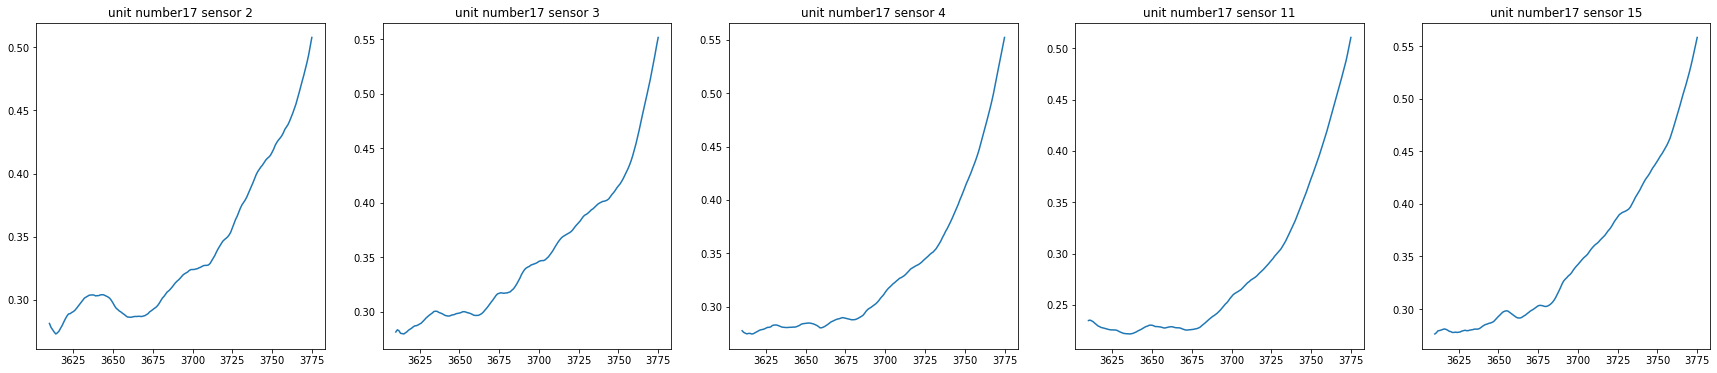

5it [00:00, 1179.24it/s]


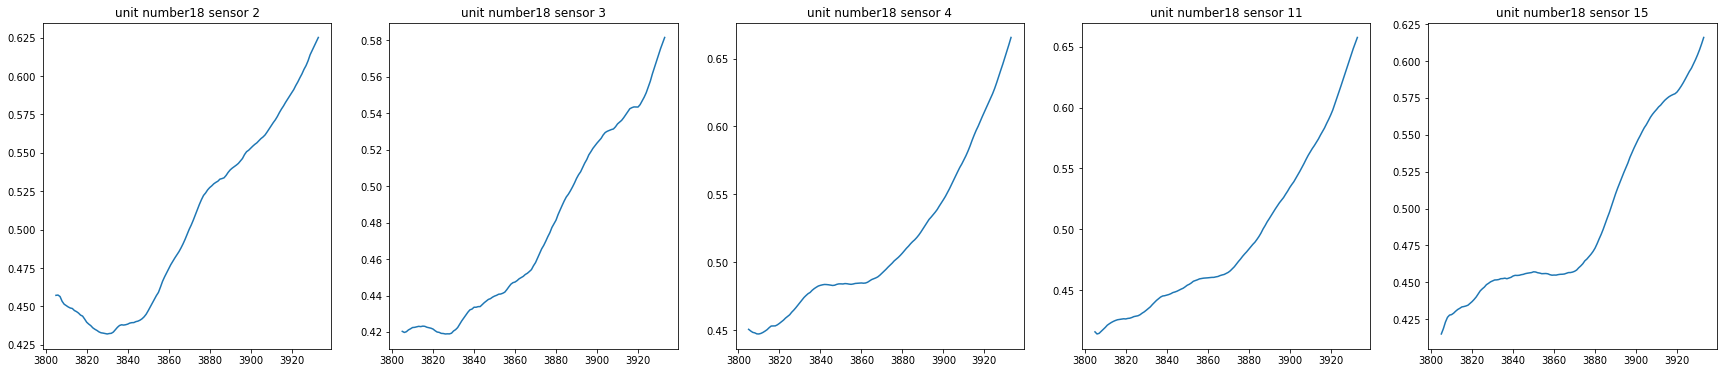

5it [00:00, 16.22it/s]


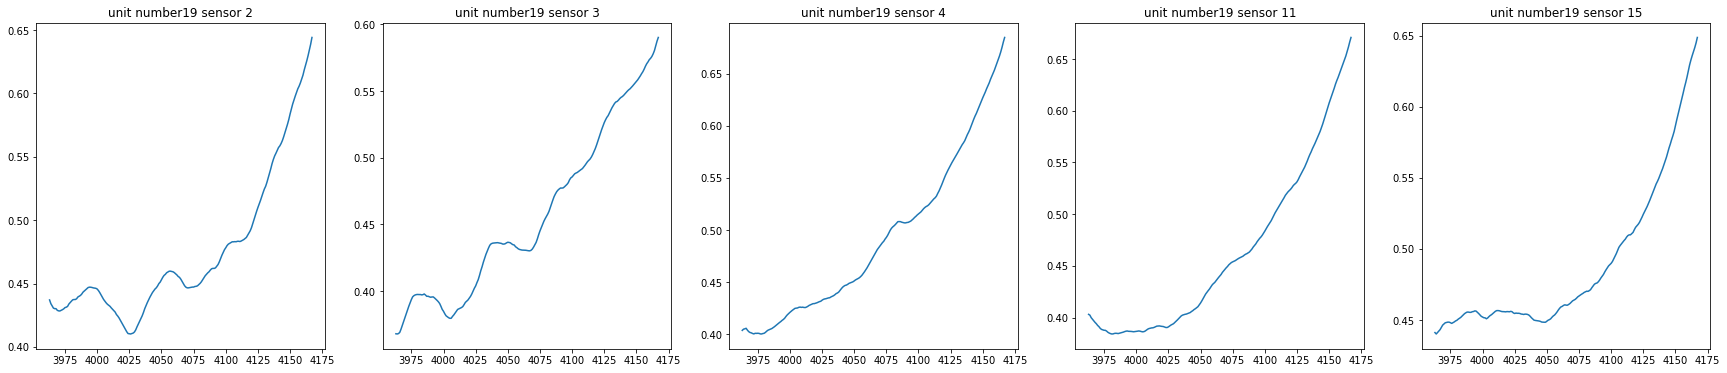

5it [00:00, 1285.73it/s]


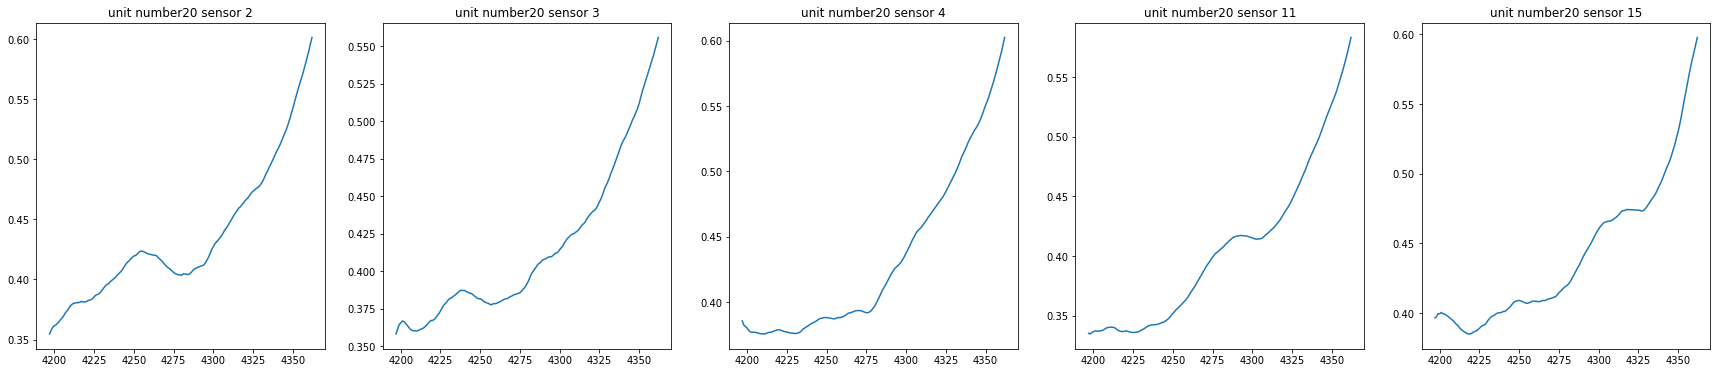

In [195]:
for key, value in enumerate(ewma_X):
    fig, ax = plt.subplots(1,5, figsize = (30,6), sharex=True)
    for i, name in tqdm(enumerate(selected_col)): 
        ax[i].plot(value[name])
        ax[i].set_title(f"unit number{key} {name}")
    if key == 20:
        break
    plt.show()

In [196]:
len(ewma_X[1])

258

In [197]:
ewma_X[0].mean(axis = 1).shape

(163,)

# Trainng session

In [198]:
def split_training_test(data, num):
    trains = data[:num]
    test = data[num:]
    
    return trains, test

def MAKE_LABEL(train, length):
    MEAN = np.zeros(shape = (length))
    N = len(train)
    for data in train:
        MEAN += data.mean(axis = 1)/N
    return MEAN

In [131]:
def PREDICTION(data, num, fig = False):
    trains, tests = split_training_test(data, num)
    y = MAKE_LABEL(trains, 163)
    
    log_y = np.log(y)
    reg = LinearRegression()
    for value in trains:
        reg.fit(value, log_y)
        #print(reg.coef_)
            
#     for i, data in tqdm(enumerate(tests)):
#         fig, ax = plt.subplots(20,5)
#         predict = np.exp(reg.predict(data))
#         ax[int(i/5),i%5].plot(predict)
#     plt.show()
    if fig == True:
        n = np.arange(len(y))
        plt.scatter(n, y, s = 200)
        for values in tqdm(tests):
            pred = np.exp(reg.predict(values))
            #print(pred)
            plt.plot(pred)
        plt.show()
    
    return reg, trains, tests, y

100%|██████████| 80/80 [00:00<00:00, 508.80it/s]


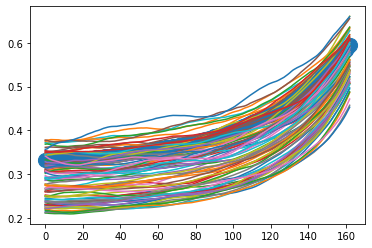

100%|██████████| 40/40 [00:00<00:00, 511.56it/s]


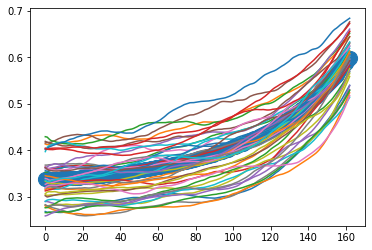

100%|██████████| 20/20 [00:00<00:00, 511.10it/s]


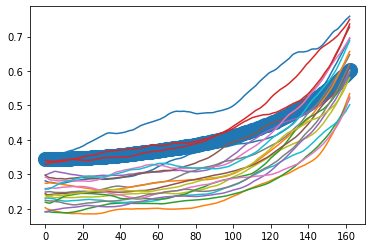

100%|██████████| 10/10 [00:00<00:00, 503.71it/s]


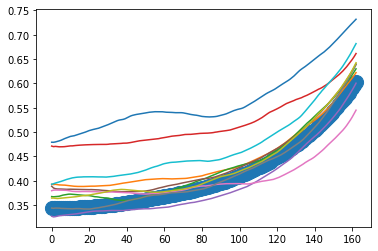

In [126]:
reg1 = PREDICTION(ewma_X,20)
reg2 = PREDICTION(ewma_X,60)
reg3 = PREDICTION(ewma_X,80)
reg4 = PREDICTION(ewma_X,90)

In [132]:
reg1, trains1, tests1, y1 = PREDICTION(ewma_X,1)

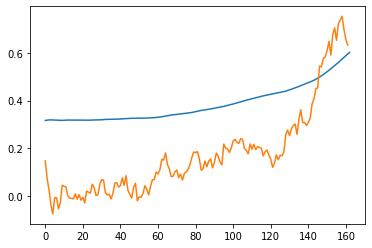

In [139]:
dif = np.diff(np.exp(reg1.predict(trains1[0]))) / 0.01
plt.plot(np.exp(reg1.predict(trains1[0])))
plt.plot(dif)

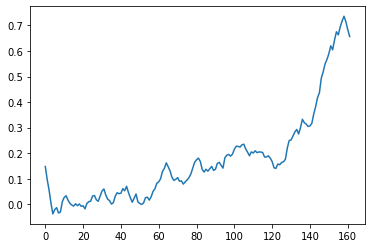

In [188]:
plt.plot(pd.DataFrame(dif).ewm(0.9).mean())yg
#pd.DataFrame(dif).ewm(1).mean()

In [ ]:
plt.plot(regg.predict(trains))

In [33]:
trains, tests = split_training_test(ewma_X, 2)
y = MAKE_LABEL(trains, 163)

In [34]:
from sklearn.linear_model import LinearRegression
log_y = np.log(y)
for data in trains:
    reg = LinearRegression().fit(data, log_y)

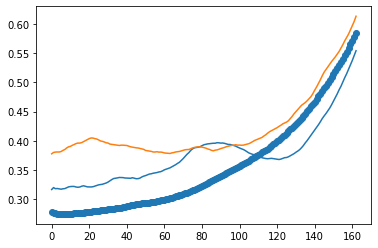

In [35]:
#plt.plot(np.exp(reg.predict(trains[0])))
tt = np.arange(len(tests[0]))
plt.scatter(tt,y)
plt.plot(np.exp(reg.predict(tests[0])))
plt.plot(np.exp(reg.predict(tests[1])))

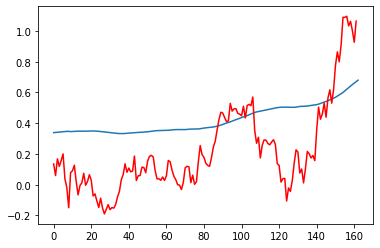

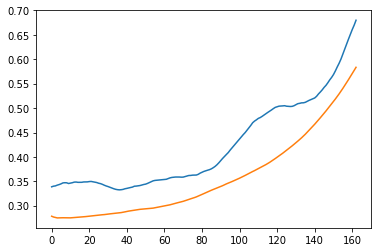

In [115]:
dd = np.exp(reg.predict(trains[0]))

ddd = np.gradient(dd)
d = np.diff(dd, n = 1) / 0.0095
plt.plot(dd)
#plt.plot(dd)
plt.plot(d, 'r')
plt.show()
plt.plot(dd)
plt.plot(y.values)

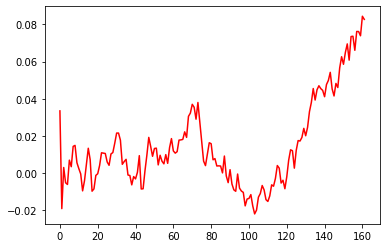

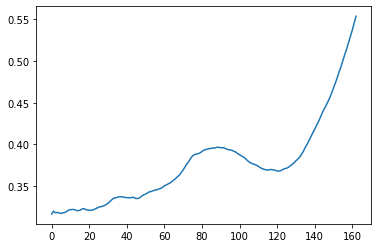

In [98]:
dd = np.exp(reg.predict(tests[0]))
ddd = np.gradient(dd)
d = np.diff(dd) / 0.1
#plt.plot(dd)
plt.plot(d, 'r')
plt.show()
plt.plot(dd)


In [80]:
print(reg.coef_)
print(reg.intercept_)
def func(x, a, X):

    return a * np.exp(np.dot(x, X))

#func(trains[0], np.exp(reg.intercept_), reg.coef_)

[ 2.0309153   0.31250861 -0.75421133  2.78376488 -2.47816679]
-1.5160337435720894


In [743]:
predict1 = np.exp(np.dot(tests[0], (reg.coef_))) * np.exp(reg.intercept_)
predict2 = np.exp(np.dot(tests[1], (reg.coef_))) * np.exp(reg.intercept_)
predict3 = np.exp(np.dot(trains[0], (reg.coef_))) * np.exp(reg.intercept_)

In [732]:
trains[0].shape

(163, 5)

In [733]:
predict3.shape

(163,)

[ 2.0309153   0.31250861 -0.75421133  2.78376488 -2.47816679]
-1.5160337435720894


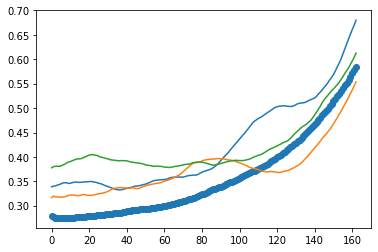

In [744]:
print(reg.coef_)
print(reg.intercept_)
tt = np.arange(len(tests[0]))
plt.scatter(tt,y)
plt.plot(predict3)
plt.plot(predict1)
plt.plot(predict2)

In [675]:
trains.shape

(326, 5)